<a href="https://colab.research.google.com/github/Elignesin/SureStart/blob/main/Feb19_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Classification in Machine Learning
The goal of this notebook is to build a basic image classification model to classify the difference between Dogs and Cats.  
This model is adopted from the model and ideas presented at https://keras.io/examples/vision/image_classification_from_scratch/.

In [25]:
#First, we should import the necessary modules and libraries
import os
import tensorflow as tf
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from keras.utils import to_categorical

In [2]:
#We're going to follow the methods in the Keras link to download the data we need
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   132M      0  0:00:05  0:00:05 --:--:--  140M


In [7]:
#I'm also going to follow their instructions for removing corrupted data
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [21]:
#This code separates the data we have into a training dataset and a validation dataset

#I'm going to shrink the image size to 128*128 to make it slightly less computationally intensive
#I'm also doubling the batch size from 32 to 64
image_size = (128, 128)
batch_size = 64

train_ds = keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.15,
    subset="training",
    seed=1693,
    image_size=image_size,
    batch_size=batch_size)

val_ds = keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.15,
    subset="validation",
    seed=1693,
    image_size=image_size,
    batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 19899 files for training.
Found 23410 files belonging to 2 classes.
Using 3511 files for validation.


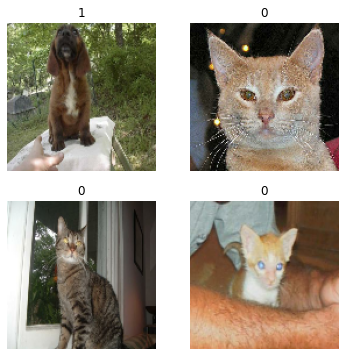

In [14]:
#Let's quickly look at some of the labeled training data
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [22]:
#Now we have to do some preprocessing steps

#First, we'll prepare to augment our data by flipping some images and rotating some slightly
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#Now we augment the data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [23]:
#This is just code to help us not crash the system when training our model
train_ds = augmented_train_ds.prefetch(buffer_size=64)
val_ds = val_ds.prefetch(buffer_size=64)

In [36]:
#Now we start to build our model
#We're going to have two convolutional layers, three dense hidden layers, and an output layer

model = Sequential()
#First convolutional layer
model.add(Conv2D(64,(3,3), activation = 'relu', padding='same', input_shape = image_size+(3,)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))
#Second convolutional layer
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(.2))
#Two Dense Hidden Layers
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation='relu'))
#Output Layer with Sigmoid Activation
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 32)       

In [37]:
#Now we're going to compile and then fit the model

epochs=10
batch_size=64

model.compile(optimizer=keras.optimizers.SGD(learning_rate = 0.001), loss="binary_crossentropy", metrics=["accuracy"])

#Fit the model
history = model.fit(train_ds, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=val_ds)

Epoch 1/10
311/311 [==============================] - 851s 3s/step - loss: 0.6821 - accuracy: 0.5676 - val_loss: 0.6690 - val_accuracy: 0.5833
Epoch 2/10
311/311 [==============================] - 850s 3s/step - loss: 0.6671 - accuracy: 0.6034 - val_loss: 0.6606 - val_accuracy: 0.5921
Epoch 3/10
311/311 [==============================] - 850s 3s/step - loss: 0.6585 - accuracy: 0.6129 - val_loss: 0.6575 - val_accuracy: 0.5927
Epoch 4/10
311/311 [==============================] - 851s 3s/step - loss: 0.6540 - accuracy: 0.6121 - val_loss: 0.6601 - val_accuracy: 0.5919
Epoch 5/10
311/311 [==============================] - 850s 3s/step - loss: 0.6491 - accuracy: 0.6219 - val_loss: 0.6596 - val_accuracy: 0.5950
Epoch 6/10
311/311 [==============================] - 852s 3s/step - loss: 0.6467 - accuracy: 0.6212 - val_loss: 0.6605 - val_accuracy: 0.5916
Epoch 7/10
311/311 [==============================] - 852s 3s/step - loss: 0.6444 - accuracy: 0.6228 - val_loss: 0.6601 - val_accuracy: 0.5953

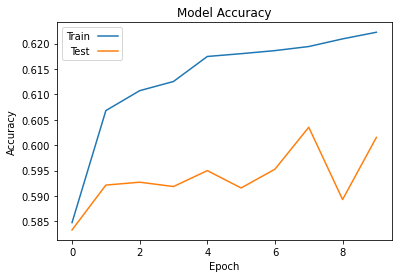

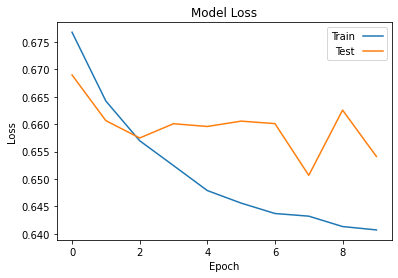

In [38]:
#Now, we want to plot our accuracy and loss for both our validation and training datasets
#This code was provided by my Surestart mentor and has been lightly modified

#Accuracy Curve
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best', markerfirst=False)
#plt.savefig('acc1.png')
plt.show()

#Loss Curve
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best', markerfirst=False)
#plt.savefig('loss1.png')
plt.show()